# Description

A taxi company is collecting historical data on airport taxi orders. To attract more drivers during peak hours, it is necessary to predict the number of taxi orders for the next hour. Create a model for such a prediction.

The RMSE metric on the test set should not exceed 48.

## Task Instructions

1. Download the data and perform resampling at one-hour intervals.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset.
4. Test the data using the test sample and provide conclusions.

## Data Description

The data is stored in the file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Import Library

In [1]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

## Import Datasets

In [3]:
try:
    df = pd.read_csv('D:/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


The data is ready for analysis. The data intentionally hasn't been preprocessed as it would affect the analysis. Because we will be analyzing the number of orders for the next 1 hour.

### Resampling Dataset

In [6]:
# resample data for an hour
df.sort_index(inplace=True)

df_hour = df.resample('1H').sum()
df_hour.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Data Analysis

<AxesSubplot:xlabel='datetime'>

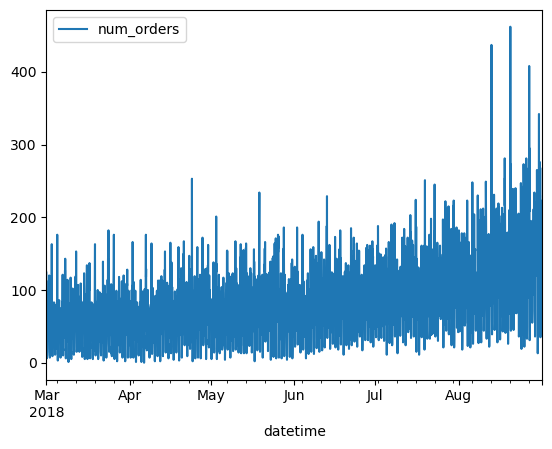

In [7]:
# plot the data
df_hour.plot()

It turns out that the plotted data cannot be clearly seen. For further analysis, the data will be examined based on trends, seasons, and residuals.

Text(0, 0.5, 'Amount Order')

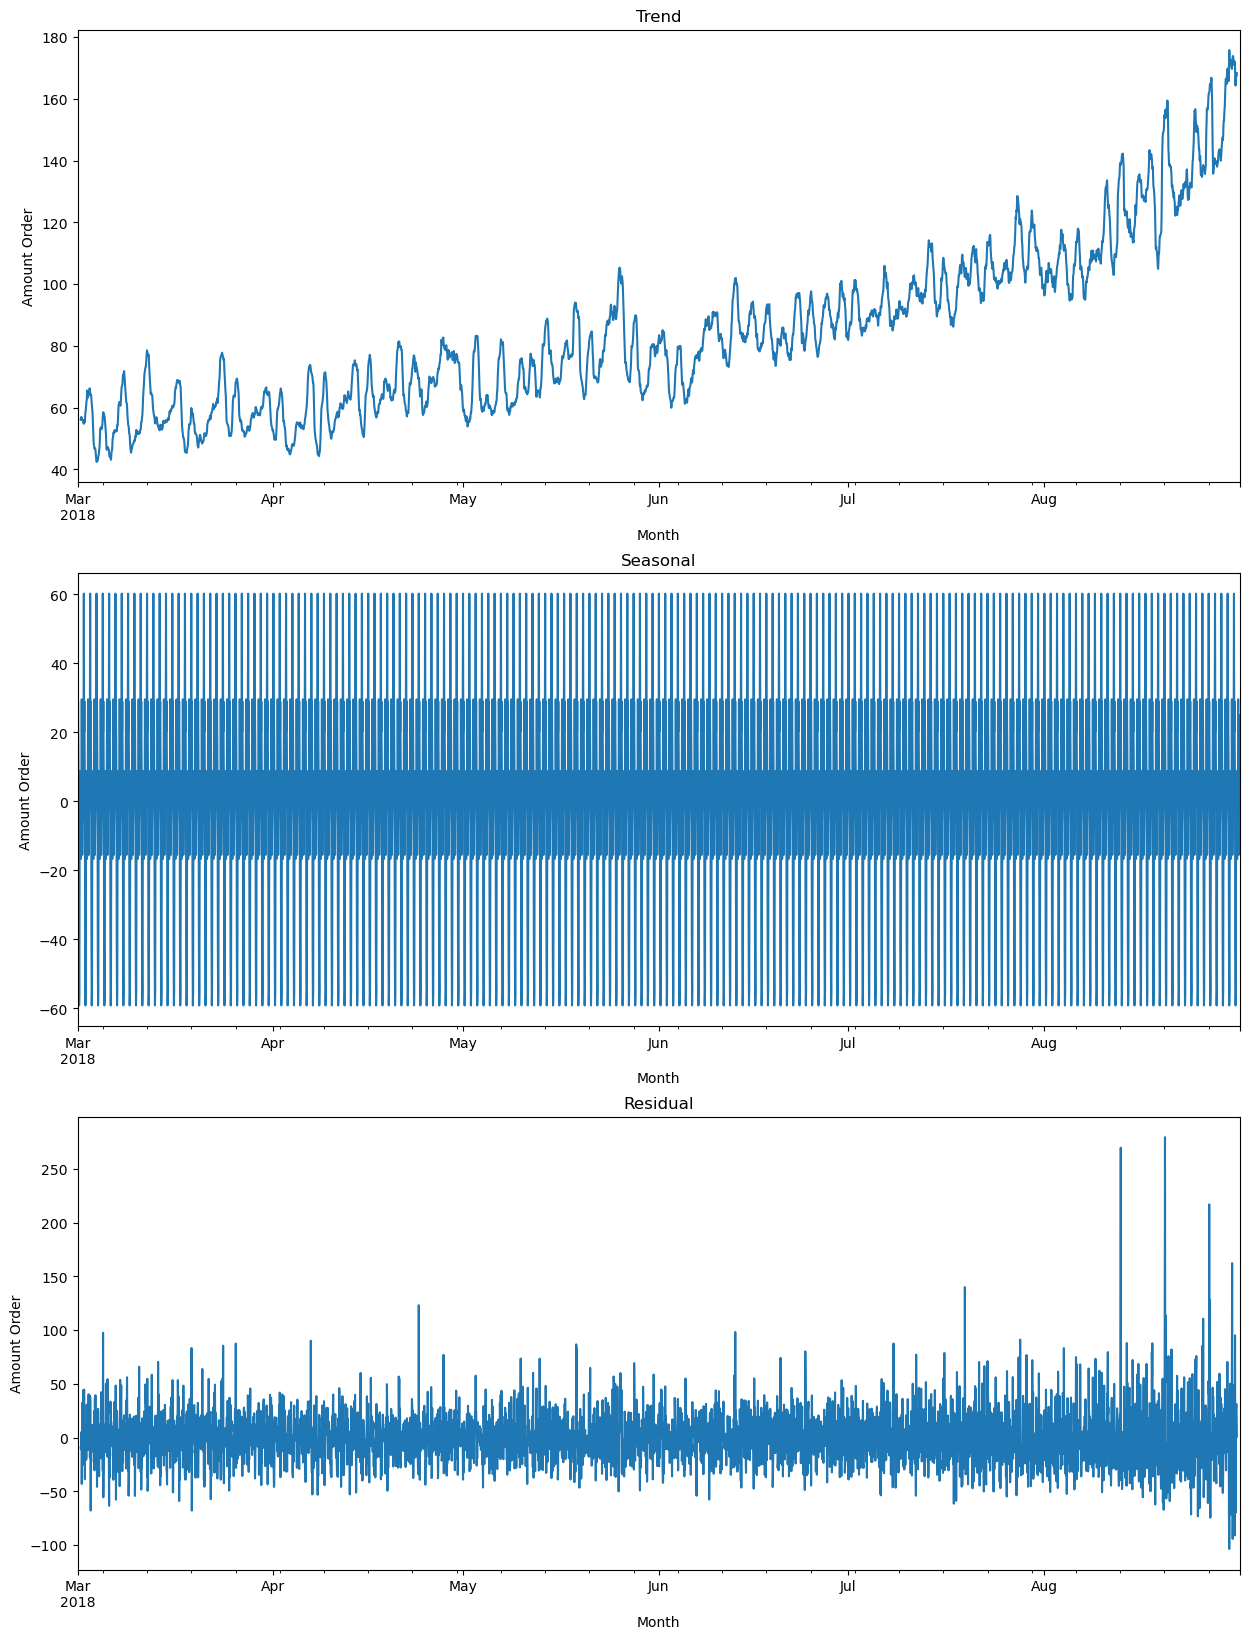

In [8]:
decomposed = seasonal_decompose(df_hour)

# creat trend, seasonal, and residue graph
plt.figure(figsize=(15,20))
# trend graph
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Month')
plt.ylabel('Amount Order')
# seasonal graph
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.xlabel('Month')
plt.ylabel('Amount Order')
# residue graph
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual')
plt.xlabel('Month')
plt.ylabel('Amount Order')

**Conclusion:**
- The first graph shows a positive trend, with an increase in the number of orders every month. The lowest number is around 40, and the highest number is around 180.
- The second graph indicates the seasonality, which is not clearly visible due to the large amount of data. However, the graph shows values around -60 and 60 on a daily basis.
- The third graph represents the residuals or noise, and it appears to have a random pattern.

Because the data we have still does not exhibit a clear seasonal pattern, we will try to resample the data on a daily basis to see which days are most frequently ordered each month.

In [9]:
# resample data for a day
df_day = df_hour.resample('1D').sum()
df_day.head()

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259


<AxesSubplot:xlabel='datetime'>

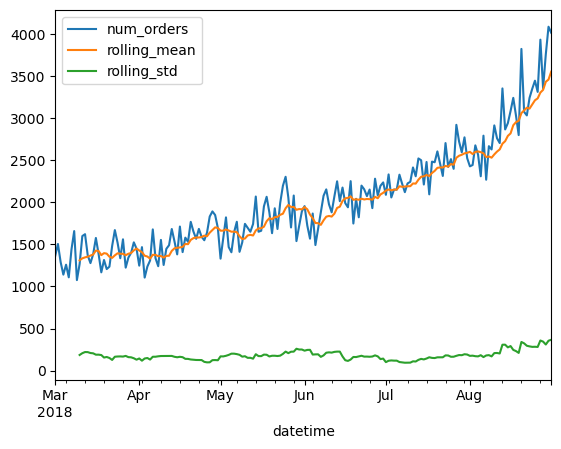

In [10]:
# create moving average with 10 windows
df_day['rolling_mean'] = df_day['num_orders'].rolling(10).mean()
# create rolling std
df_day['rolling_std'] = df_day['num_orders'].rolling(10).std()

# graph by day
df_day.plot()

The graph above shows an upward trend. The mean values are very smooth, and similarly, there are no extreme values in the standard deviation. All values in the graph appear to be quite smooth.

Next, we will look at the data grouped by week. So, we will take data starting from the beginning of the month, which is from the 15th to the 21st of each month. Thus, every 7 days, we will observe the fluctuations over a 7-day period. As an example, we will take data from April 15th to April 21st, as we can see the trend starting to rise from April.

Text(0, 0.5, 'Amount Order')

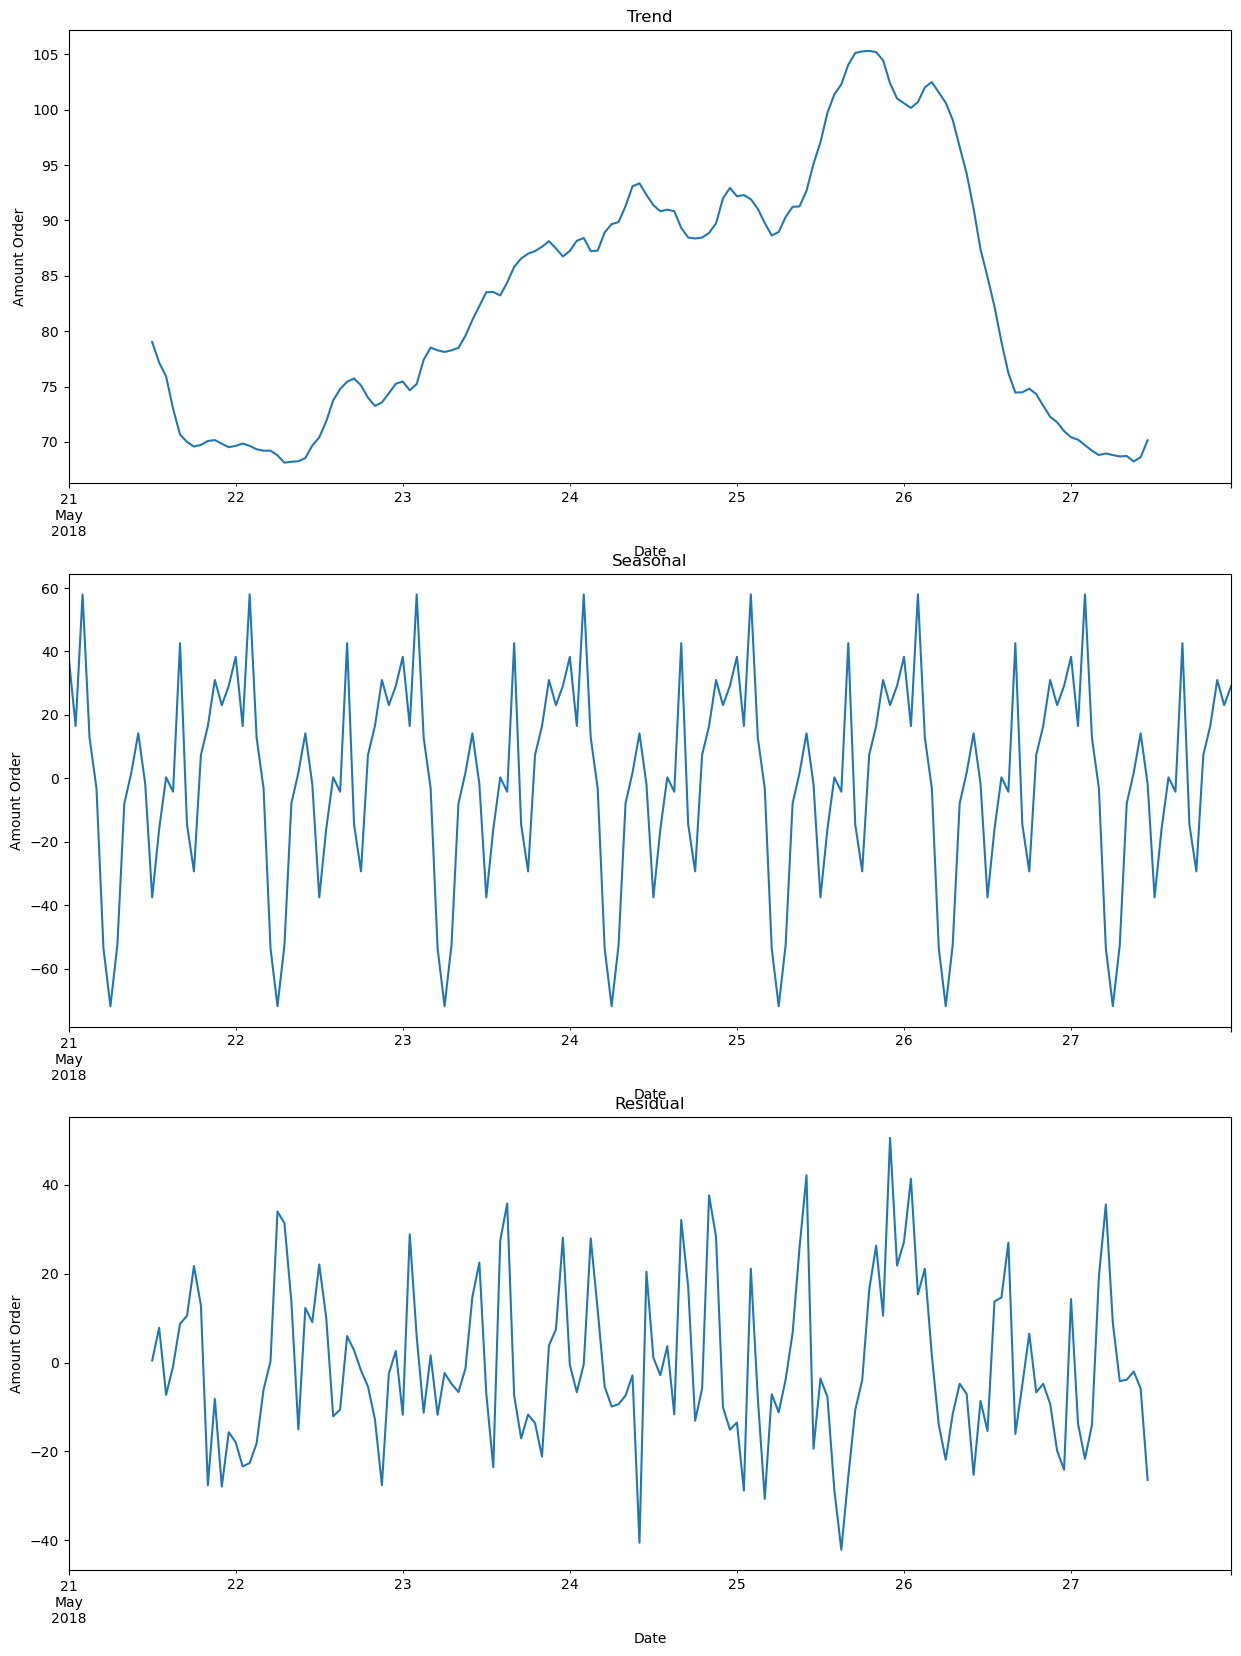

In [11]:
decomposed_week = seasonal_decompose(df_hour['2018-05-21':'2018-05-27'])

# creat trend, seasonality, and residue graph
plt.figure(figsize=(15,20))
# trend graph
plt.subplot(311)
decomposed_week.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Amount Order')
# seasonality graph
plt.subplot(312)
decomposed_week.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')
plt.xlabel('Date')
plt.ylabel('Amount Order')
# residue graph
plt.subplot(313)
decomposed_week.resid.plot(ax=plt.gca())
plt.title('Residual')
plt.xlabel('Date')
plt.ylabel('Amount Order')

**Based on the above graph:**
- The first graph shows a trend where the highest number of orders occurred on Saturday, the 26th of the month.
- The second graph shows fluctuations with the same pattern. This indicates that the fluctuations change consistently every 1 hour.
- The third graph represents the residuals.

<AxesSubplot:xlabel='datetime'>

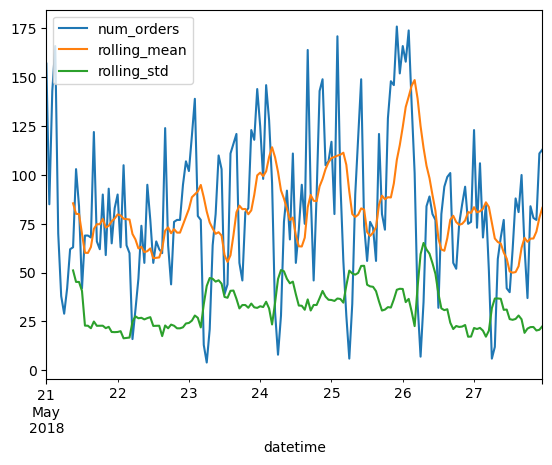

In [12]:
df_week = df_hour['2018-05-21':'2018-05-27']
df_week['rolling_mean'] = df_week['num_orders'].rolling(10).mean()
df_week['rolling_std'] = df_week['num_orders'].rolling(10).std()

df_week.plot()

The graph indicates that the average values and standard deviation are higher on Saturday, the 26th. The second highest number of orders occurs on weekdays or working days. However, these weekdays show a significant drop in values at the beginning of the day.

**Conclusion:**
The day with the highest number of orders is Saturday, while the lowest number of orders occurs at the early hours around 6 AM. The peak times are in the afternoon and midnight.

## Traininig Model

In [13]:
# function to make featires
def make_features(data, max_lag, rolling_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag+1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_size).mean()

# apply the function on the data
make_features(df_hour, 7, 24)
df_hour.dropna(inplace=True)
df_hour.head()

,num_orders,year,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,rolling_mean
datetime,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,2018,3,2,4,0,58.0,113.0,66.0,61.0,45.0,73.0,44.0,56.833333
2018-03-02 01:00:00,120,2018,3,2,4,1,90.0,58.0,113.0,66.0,61.0,45.0,73.0,55.416667
2018-03-02 02:00:00,75,2018,3,2,4,2,120.0,90.0,58.0,113.0,66.0,61.0,45.0,56.875000
2018-03-02 03:00:00,64,2018,3,2,4,3,75.0,120.0,90.0,58.0,113.0,66.0,61.0,57.041667
2018-03-02 04:00:00,20,2018,3,2,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,56.958333


In [14]:
# split the data into train and test
train, test = train_test_split(df_hour, test_size=0.1, shuffle=False, random_state=42)

# split the data into features and target
feature_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
feature_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

print(feature_train.shape)
print(target_train.shape)
print(feature_test.shape)
print(target_test.shape)

(3952, 13)
(3952,)
(440, 13)
(440,)


## Testing

The data is ready, and next, we will proceed with testing the models. The models to be used are:

- Linear Regression, for a sanity check.
- Random Forest Regressor, for model training as a comparison to boosting models.
- LightGBM (LGBM), as a comparison to the Random Forest Regressor.

## RMSE Function

In [15]:
def calculate_rmse(y_true, y_pred):
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse
scorer = make_scorer(calculate_rmse, greater_is_better=False)

## Linear Regression

In [16]:
# linear regression model
lr = LinearRegression()
lr.fit(feature_train, target_train)
predict_train = lr.predict(feature_train)
predict_test = lr.predict(feature_test)

# RMSE score
print('RMSE on training set:', calculate_rmse(target_train, predict_train))
print('RMSE on testing set:', calculate_rmse(target_test, predict_test))

RMSE on training set: 30.417762051449074
RMSE on testing set: 51.312420588405324


As previously shown, the RMSE value on the training set is lower than that on the testing set. With this, we have completed the sanity check and will proceed with testing the next model using the testing set.

## Random Forest Regressor

In [17]:
# simple hyperparameter tuning
for depth in range(1, 10):
    rfr = RandomForestRegressor(n_estimators=50, max_depth=depth, random_state=42)
    rfr_score = -cross_val_score(rfr, feature_train, target_train, cv=5, scoring=scorer)
    print("Max Depth:", depth, "Score:", rfr_score.mean())

Max Depth: 1 Score: 34.94979734290412
Max Depth: 2 Score: 32.75366883490467
Max Depth: 3 Score: 29.489069604857583
Max Depth: 4 Score: 27.690258270235205
Max Depth: 5 Score: 26.322255723326293
Max Depth: 6 Score: 25.584349429564266
Max Depth: 7 Score: 25.044310648518383
Max Depth: 8 Score: 24.74458123374314
Max Depth: 9 Score: 24.50453438384435


For the Random Forest Regressor with 50 estimators and a maximum depth of 9, it obtained the lowest RMSE score. This indicates that these parameters will be tested on the testing data.

In [18]:
# testing Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=50, max_depth=9, random_state=42)
%time rfr.fit(feature_train, target_train)

Wall time: 2.06 s


RandomForestRegressor(max_depth=9, n_estimators=50, random_state=42)

In [19]:
%time predict_rfr = rfr.predict(feature_test)
print("RMSE Score:", calculate_rmse(target_test, predict_rfr))

Wall time: 13.5 ms
RMSE Score: 45.31713027820813


Nilai yang kita dapatkan lebih bagus daripada Linear Regression. Dengan waktu yang begitu singkat

## LGBM

In [20]:
# hyperparameter tuning using GridSearchCV
lgbm = LGBMRegressor()
params = {
    'num_leaves':[10, 20, 30],
    'learning_rate':[0.5, 0.1],
    'n_estimators':[10, 20],
    'objective':['rmse'],
    'random_seed':[42]
}
grid_cv = GridSearchCV(estimator=lgbm, param_grid=params, scoring=scorer, cv=5, n_jobs=-1)
grid_cv.fit(feature_train, target_train)
best_params = grid_cv.best_params_

In [21]:
print('Best Score:', -grid_cv.best_score_)
print('Best Parameter:', best_params)

Best Score: 24.25344803478449
Best Parameter: {'learning_rate': 0.5, 'n_estimators': 10, 'num_leaves': 30, 'objective': 'rmse', 'random_seed': 42}


In [22]:
# testing on data testing
lgbm1 = LGBMRegressor(learning_rate=0.5, n_estimators=10, num_leaves=30, objective='rmse', random_seed=42)
%time lgbm1.fit(feature_train, target_train)

Wall time: 46.1 ms


LGBMRegressor(learning_rate=0.5, n_estimators=10, num_leaves=30,
              objective='rmse', random_seed=42)

In [23]:
%time lgbm_predict = lgbm1.predict(feature_test)
print('RMSE Score:', calculate_rmse(target_test,lgbm_predict))

Wall time: 2.52 ms
RMSE Score: 44.412265827226854


Although the RMSE values only have a slight difference, using boosting models resulted in faster training and testing times.

## Conclusion

In [24]:
data = {
    'RMSE':[calculate_rmse(target_test, predict_test),
    calculate_rmse(target_test, predict_rfr),
    calculate_rmse(target_test,lgbm_predict)]
}

summary = pd.DataFrame(data=data, index=['LR', 'RFR', 'LGBM'])
summary

,RMSE
LR,51.312421
RFR,45.317130
LGBM,44.412266


**Data Analysis:**
- The time series data was managed, and after dividing it into trend, seasonality, and residual components, it was observed that the data has a positive trend. The seasonality pattern shows values ranging from 60 to -60 each day, indicating that there are times when people place more orders and times when fewer orders are placed.
- To gain further insights into the time series data, a closer look was taken at the data for the month of May, where a spike began to occur. Data for one week was examined, revealing that the highest number of orders occurred on Saturdays.
- There was a peak, with the graph initially declining at the start of the day and then showing an increase in the middle.

**Training and Testing Data:**
- The data was trained using three regression models: Linear Regression as a sanity check, Random Forest Regressor as a comparison with gradient boosting models, and one gradient boosting model, LightGBM, as a comparison with Random Forest Regressor.
- Among these three models, only Linear Regression had the highest RMSE value and exceeded the predefined limit.
- Among these three models, LGBM and RFR had lower RMSE values than the predefined limit. However, LGBM maintained the advantage of faster training and testing times.